In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

monday = pd.read_csv('data/monday.csv', sep=';')
tuesday = pd.read_csv('data/tuesday.csv', sep=';')
wednesday = pd.read_csv('data/wednesday.csv', sep=';')
thursday = pd.read_csv('data/thursday.csv', sep=';')
friday = pd.read_csv('data/friday.csv', sep=';')

DAYS = [monday, tuesday, wednesday, thursday, friday]

In [3]:
for day in DAYS:
    # set timestamp as datetime and as index
    day.timestamp = pd.to_datetime(day.timestamp)
    day.set_index('timestamp', inplace=True)

    # Kick out customers that do not check out
    all_customers = set(day.customer_no.values)
    checked_out_customers = set(day[day['location'] == 'checkout'].customer_no.values)
    non_checked_out_customers = list(all_customers.difference(checked_out_customers))
    day = day[~day.loc[:, 'customer_no'].isin(non_checked_out_customers)]
    print(f'''The customers that have not checked out on {day.index[0].day_name()} are {non_checked_out_customers}''')

for day in DAYS:
    # add the customer count
    day['nr_loc'] = day.groupby('customer_no').cumcount()
    add_customer = day.loc[:, 'nr_loc'].transform(lambda x: 1 if x == 0 else 0)
    delete_customer = day.loc[:, 'location'].transform(lambda x: -1 if x == 'checkout' else 0)
    day['add'] = add_customer + delete_customer
    day['cust_total'] = day.loc[:, 'add'].cumsum()

The customers that have not checked out on Monday are [1440, 1441, 1443, 1445, 1446, 1447, 1430, 1433, 1437, 1439]
The customers that have not checked out on Tuesday are [1411, 1422]
The customers that have not checked out on Wednesday are [1520, 1527, 1528, 1529, 1530]
The customers that have not checked out on Thursday are [1532, 1533, 1527]
The customers that have not checked out on Friday are [1505, 1506, 1509, 1510, 1494, 1496, 1500, 1503]


In [4]:
monday.info()
monday.head()
monday.tail()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4884 entries, 2019-09-02 07:03:00 to 2019-09-02 21:50:00
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   customer_no  4884 non-null   int64 
 1   location     4884 non-null   object
 2   nr_loc       4884 non-null   int64 
 3   add          4884 non-null   int64 
 4   cust_total   4884 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 228.9+ KB


,customer_no,location,nr_loc,add,cust_total
timestamp,,,,,
2019-09-02 21:49:00,1442,checkout,1,-1,8
2019-09-02 21:49:00,1444,checkout,1,-1,7
2019-09-02 21:49:00,1445,dairy,0,1,8
2019-09-02 21:50:00,1446,dairy,0,1,9
2019-09-02 21:50:00,1447,fruit,0,1,10


In [5]:
# Add the day
monday['day'] = 'monday'
tuesday['day'] = 'tuesday'
wednesday['day'] = 'wednesday'
thursday['day'] = 'thursday'
friday['day'] = 'friday'

# combine the DataFrames
total = monday.append(tuesday.append(wednesday.append(thursday.append(friday))))
total.shape
total.head()

,customer_no,location,nr_loc,add,cust_total,day
timestamp,,,,,,
2019-09-02 07:03:00,1,dairy,0,1,1,monday
2019-09-02 07:03:00,2,dairy,0,1,2,monday
2019-09-02 07:04:00,3,dairy,0,1,3,monday
2019-09-02 07:04:00,4,dairy,0,1,4,monday
2019-09-02 07:04:00,5,spices,0,1,5,monday


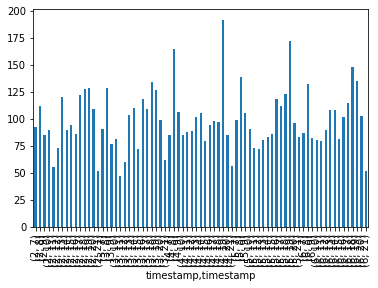

<Figure size 1440x1440 with 0 Axes>

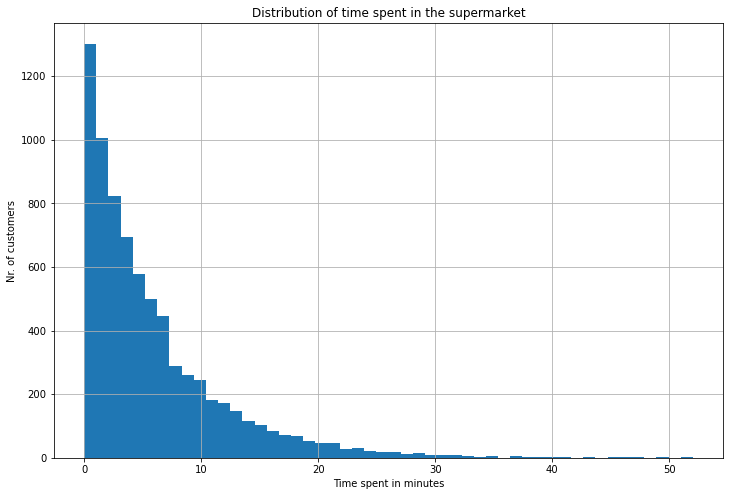

In [6]:
### Use resample to make it easier to calculate the nr. of customers at each point
### in time 
total.columns
total = total.groupby(['customer_no', 'day']).resample('min').ffill()

total.index = total.index.droplevel([0, 1])

# Inspect the count per location
total.groupby('location')['customer_no'].count()
total.groupby(by=[total.index.day, total.index.hour, total.index.hour, 'location'])['customer_no'].count()


### Display the number of customers at checkout over time

total.groupby(by=[total.index.day, total.index.hour, 'location'])['customer_no'].count().unstack(2)['checkout'].plot(kind='bar')
plt.figure(figsize=(20, 20))
plt.show()


### Calculate the time each customer spent in the market

time_ = total.reset_index()
time_in_market = time_.groupby(['customer_no', 'day'])[['timestamp']].last() - time_.groupby(['customer_no', 'day'])[['timestamp']].first()
time_in_market['counter'] = 1
time_in_market.head()
time_in_market['time_spent'] = time_in_market.timestamp.dt.seconds/60
time_in_market.hist(column='time_spent', figsize=(12, 8), bins=50)
plt.xlabel('Time spent in minutes')
plt.ylabel('Nr. of customers')
plt.title('Distribution of time spent in the supermarket')
plt.show()

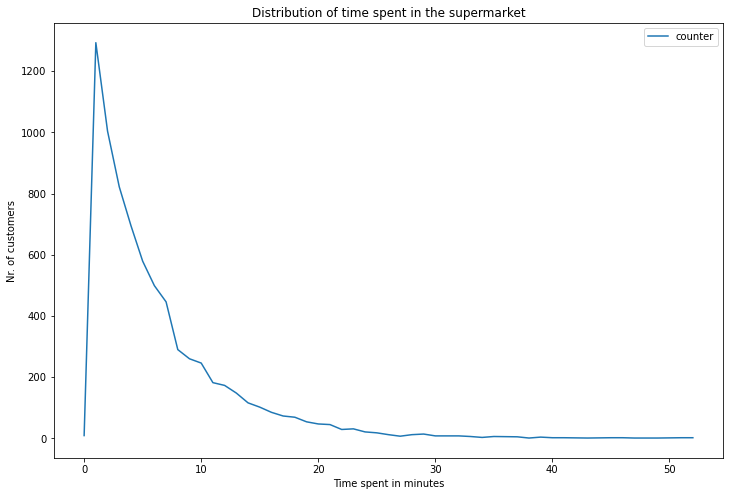

In [7]:
time_count = time_in_market.groupby('timestamp').count()
time_count.shape
time_count.reset_index(inplace=True)
time_count['time_spent'] = time_count.timestamp.dt.seconds/60
time_count.head()


time_count.plot(x='time_spent', y='counter', figsize=(12, 8))#.bar(x='timestamp', height='count')
plt.xlabel('Time spent in minutes')
plt.ylabel('Nr. of customers')
plt.title('Distribution of time spent in the supermarket')
plt.show()

In [8]:
#time_count.time_spent.value_counts()
time_count.shape

(48, 3)

<AxesSubplot:xlabel='timestamp'>

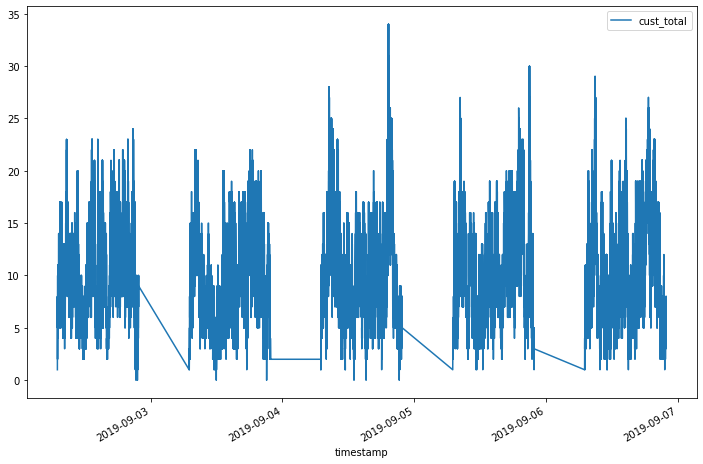

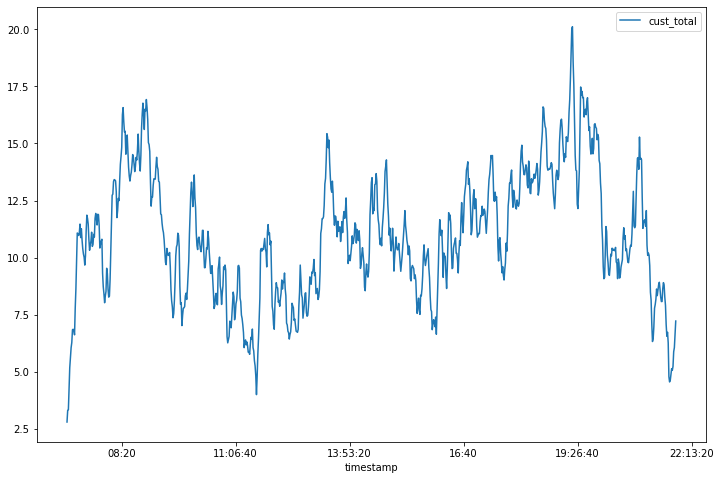

In [9]:
### Calculate the total number of customers present in the supermarket over time.

# make sure each customer only enters the supermarket max once a day
total[total.location == 'checkout'].groupby(['customer_no', 'day']).count().max()
len(set(monday.customer_no.values).difference())
len(set(monday[monday.location == 'checkout'].customer_no.values))

# plot number of totatl customers
total.reset_index().plot(x='timestamp', y='cust_total', figsize=(12, 8))


# Create a plot with average nr. of customers per time over one day
# Group by timestep
daily = total.reset_index()
daily.timestamp = daily.timestamp.transform(lambda x: x.time())
daily.head()


daily.groupby('timestamp')['cust_total'].mean().reset_index().plot(x='timestamp', y='cust_total', figsize=(12, 8))

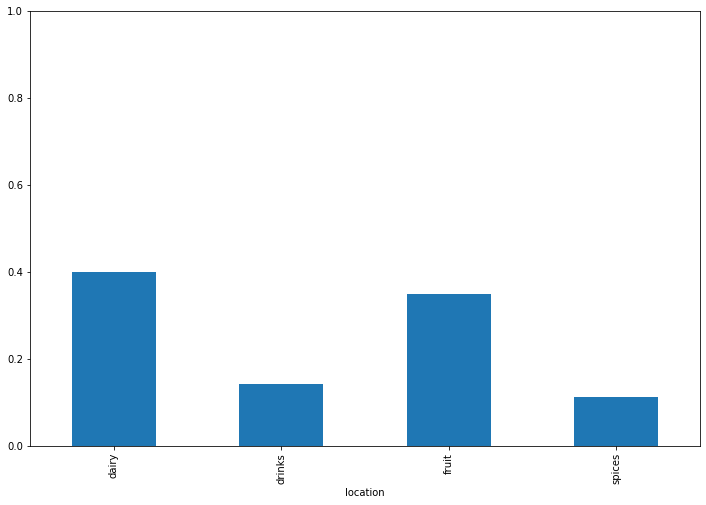

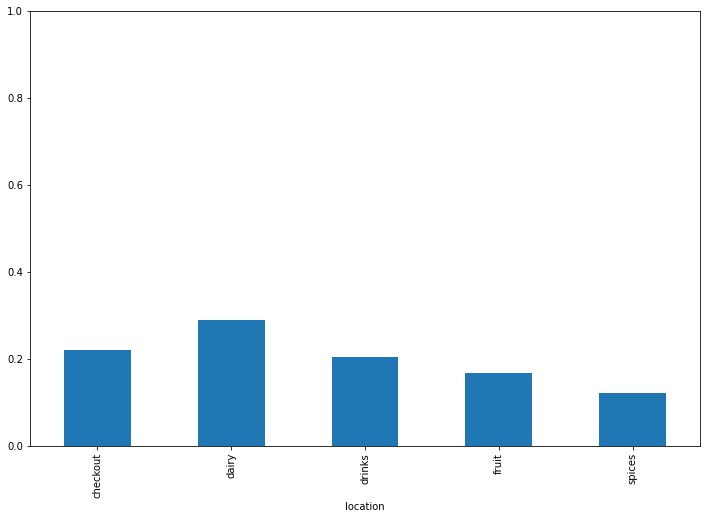

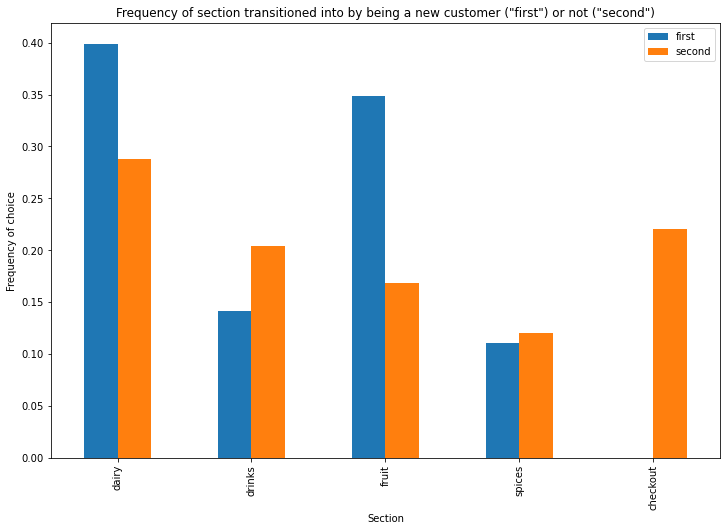

In [12]:
#### Our business managers think that the first section customers visit follows a different pattern than the following ones. Plot the distribution of customers of their first visited section versus following sections (treat all sections visited after the first as “following”).

total_firsts = total[total['add']==1].shape[0]
freq_firsts = total[total['add']==1].groupby('location').count()['customer_no']/total_firsts
freq_firsts.plot.bar(figsize=(12, 8))
plt.axis(ymin=0, ymax=1)
plt.show()


total_seconds = total[total['add']!=1].shape[0]
freq_seconds = total[total['add']!=1].groupby('location').count()['customer_no']/total_seconds
#freq_firsts.plot.bar(figsize=(12, 8), color='r')
freq_seconds.plot.bar(figsize=(12, 8))
plt.axis(ymin=0, ymax=1)
plt.show()


pd.DataFrame([freq_firsts, freq_seconds], index=['first', 'second']).transpose().plot.bar(figsize=(12, 8))
plt.title('Frequency of section transitioned into by being a new customer ("first") or not ("second")')
plt.xlabel('Section')
plt.ylabel('Frequency of choice')
plt.show()

<ipython-input-10-c83cb4a393f4>:25: FutureWarning: Passing <class 'int'> to shift is deprecated and will raise in a future version, pass Timestamp instead.
  minutes_spent['time_next'] = minutes_spent.groupby(['customer_no', 'day'])['timestamp'].transform(lambda x: x.shift(-1, fill_value=0)-x)


AxesSubplot(0.125,0.125;0.775x0.755)


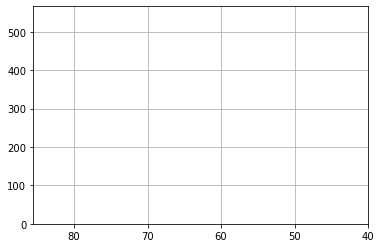

AxesSubplot(0.125,0.125;0.775x0.755)


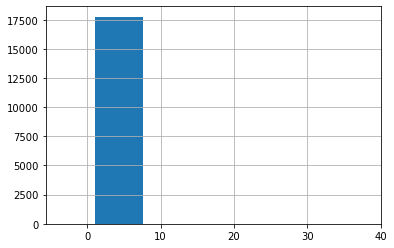

AxesSubplot(0.125,0.125;0.775x0.755)


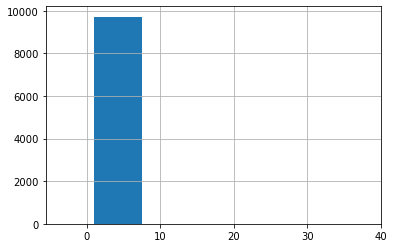

AxesSubplot(0.125,0.125;0.775x0.755)


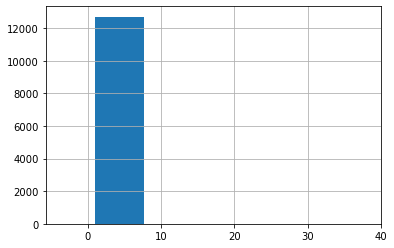

AxesSubplot(0.125,0.125;0.775x0.755)


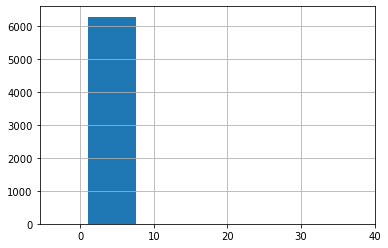

In [10]:

#


# ### Estimate the total revenue for a customer value using the following table:

prices = pd.DataFrame(index=['fruit', 'spices', 'dairy', 'drinks'], columns=['revenue per minute in €'], data=[4, 3, 5, 6])
prices


# Calculate the average time per customer spent in each section


minutes_spent = total.reset_index()
minutes_spent.head()


#minutes_spent['time'] = minutes_spent.timestamp.transform(lambda x: x.time())
minutes_spent['day'] = minutes_spent.timestamp.apply(lambda x: x.day)
#minutes_spent.head()


g = minutes_spent.groupby(['customer_no', 'day'])


minutes_spent['time_next'] = minutes_spent.groupby(['customer_no', 'day'])['timestamp'].transform(lambda x: x.shift(-1, fill_value=0)-x)
minutes_spent['time_next'] = minutes_spent.time_next.transform(lambda x: int(x.seconds/60))
minutes_spent.head(10)


# int(minutes_spent.time_next[0].seconds/60)


# Calculate average time spent by section
minutes_spent.groupby('location')['time_next'].mean()


# Actually look at the distribution first
for group, df_group in minutes_spent.groupby('location')['time_next']:
    print(df_group.hist(bins=20))
    plt.axis(xmax=40)
    plt.show()

In [14]:
freq_firsts

location
dairy     0.399159
drinks    0.141677
fruit     0.348603
spices    0.110561
Name: customer_no, dtype: float64

In [13]:
#### Calculate the initial state probabilities

freq_firsts.to_csv('initial_probabilities.csv')

#### Calculate the transition probabilities

total['transition'] = total.groupby(['day', 'customer_no'])['location'].shift(-1).fillna('checkout')
P = pd.crosstab(total[total['add']!=1]['location'], total[total['add']!=1]['transition'], normalize=0)
assert all(P.sum(axis=1))==1
P.to_csv('transition_probability_matrix.csv')

P

transition,checkout,dairy,drinks,fruit,spices
location,,,,,
checkout,1.000000,0.000000,0.000000,0.000000,0.000000
dairy,0.101597,0.738485,0.054611,0.053787,0.051520
drinks,0.215098,0.005392,0.597493,0.090061,0.091956
fruit,0.202791,0.093976,0.057410,0.591592,0.054231
spices,0.146921,0.189711,0.163987,0.093742,0.405639
